In [1]:
%load_ext autoreload
%autoreload 2
from mira.sources.amr.petrinet import *
from mira.modeling.amr.petrinet import *
from mira.metamodel.template_model import *
import sympy as sp
from mira.metamodel.utils import *
from mira.metamodel.templates import *
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model
import numpy as np

import matplotlib.pyplot as plt



In [2]:
model = model_from_json_file(
    "notebooks/hackathon_2024.12/ModelA_base_petri.json"
)

In [8]:
S_p = Concept(name="S_p")
E_p = Concept(name="E_p")
I_p = Concept(name="I_p")
R_p = Concept(name="R_p")
lambda_p = safe_parse_expr("beta_pp*I_p/(S_p+E_p+I_p+R_p)")

t1 = NaturalProduction(outcome=S_p, rate_law=safe_parse_expr("pi_p"))
t2 = NaturalDegradation(subject=S_p, rate_law=safe_parse_expr("mu_p*S_p"))
t3 = GroupedControlledConversion(
    subject=S_p,
    outcome=E_p,
    controllers=[E_p, R_p, I_p],
    rate_law=lambda_p * safe_parse_expr("S_p"),
)

t4 = NaturalDegradation(
    subject=E_p, rate_law=safe_parse_expr("E_p*(mu_p + sigma_p)")
)
t5 = ControlledProduction(
    outcome=I_p, rate_law=safe_parse_expr("E_p*sigma_p"), controller=I_p
)
t6 = NaturalDegradation(
    subject=I_p, rate_law=safe_parse_expr("I_r*(delta_p+mu_p+tau_p)")
)
t7 = NaturalDegradation(subject=R_p, rate_law=safe_parse_expr("R_p*mu_p"))
t8 = ControlledProduction(
    outcome=R_p, rate_law=safe_parse_expr("I_p*tau_p"), controller=R_p
)


t9 = NaturalConversion(
    subject=I_p,
    outcome=model.get_concept("S_h"),
    rate_law=safe_parse_expr(
        "beta_ph * I_p/(S_p + E_p + I_p + R_p ) * (rho*S_h) + (rho*pi_h)"
    ),
)
t10 = NaturalConversion(
    subject=I_p,
    outcome=model.get_concept("S_l"),
    rate_law=safe_parse_expr(
        "beta_ph * I_p/(S_p+ E_p + I_p + R_p ) * ((1-rho) * S_l) + ((1-rho)*pi_h)"
    ),
)
t11 = NaturalConversion(
    subject=model.get_concept("I_r"),
    outcome=S_p,
    rate_law=safe_parse_expr("beta_rp * I_r/(S_r+E_r+I_r+R_r) * S_p * pi_p"),
)

# pet recruitment rate 
# Not sure if to use integer like pi_h (2,500) in paper or normalized value like pi_r (.5) in paper
# Opted to do float like with rats and set it lower than .5 as I assume that rats proliferate at a faster rate than pets 
model.add_parameter("pi_p", value=0.25)

# pet natural death rate 
# Decided to set it one magnitude lower than natural death rate for rodents
model.add_parameter("mu_p", value=0.0003)

# pet progression rate 
# Set it on the same magnitude as humans but lower than humans as humans are exposed more to the disease in general
# However, set it on the same magnitude as pets are always in close proximity to humans 
model.add_parameter("sigma_p", value=0.015)

# pet mpox induced death rate 
# Set it between human and rodent mpox induced death rate as pets usually recieve better health-care than rodents 
# but worse health-care than humans
model.add_parameter("delta_p", value=0.01)

# pet recovery rate 
# Not sure if I was reading this correctly but I'm suprised to see that the recovery rate for rodents (tau_r = 0.08) is 
# higher than the human recovery rate. And the recovery rate from mildly infected to recovered (tau_1 = 0.048) is lower than the recovery rate from 
# severely infected to recovered (tau_2 = 0.05). 
model.add_parameter("tau_p", value=0.070)

# infection rates between pets must be lower than infection rate between rodents (beta_rr = 0.025)
model.add_parameter("beta_pp", value=0.015)
# infection rates between pets and humans must be higher than infection rate between rodent and humans (beta_rh = .3045) 
model.add_parameter("beta_ph", value=0.4045)
# infection rate between rodents and pets. No requirement for this but since beta_rh = 0.3045, and humans are more likely to come in 
# contact with rodents, I set beta_rp less than beta_rh
model.add_parameter("beta_rp", value=0.2045)


templates_to_add = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11]
model.templates.extend(templates_to_add)
initials = {
    'S_p': Initial(concept=Concept(name='S_p'), expression=SympyExprStr(sp.Float(5e4))),
    'E_p': Initial(concept=Concept(name='E_p'), expression=SympyExprStr(sp.Float(500))),
    'I_p': Initial(concept=Concept(name='I_p'), expression=SympyExprStr(sp.Float(10))),
    'R_p': Initial(concept=Concept(name='R_p'), expression=SympyExprStr(sp.Float(1))),
}
model.initials.update(initials)



In [9]:
om = OdeModel(Model(model), initialized=True)



In [10]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(S_l, t), =,                                                               I_p*S_l*beta_ph*(1 - rho)/(E_p + I_p + R_p + S_p) - S_l*mu_h - S_l*nu*(I_r*beta_rh/(E_r + I_r + R_r + S_r) + beta_hh*(I1*eta + I2 + P*alpha)/(E_h + H + I1 + I2 + P + R_h + S_h + S_l)) + 2*pi_h*(1 - rho)],
[  Derivative(P, t), =,                                                                                                                                                                                                                                           E_h*sigma_h - P*(mu_h + omega)],
[  Derivative(H, t), =,                                                                                                                                                                                                                               -H*(delta_h + mu_h + tau3) + I1*k1 + I2*k2],
[Derivative(S_r, t), =,                                                                                               

In [13]:
nweeks = 35
times = np.linspace(0, nweeks*7, nweeks)
res = simulate_ode_model(om, times, with_observables=True)

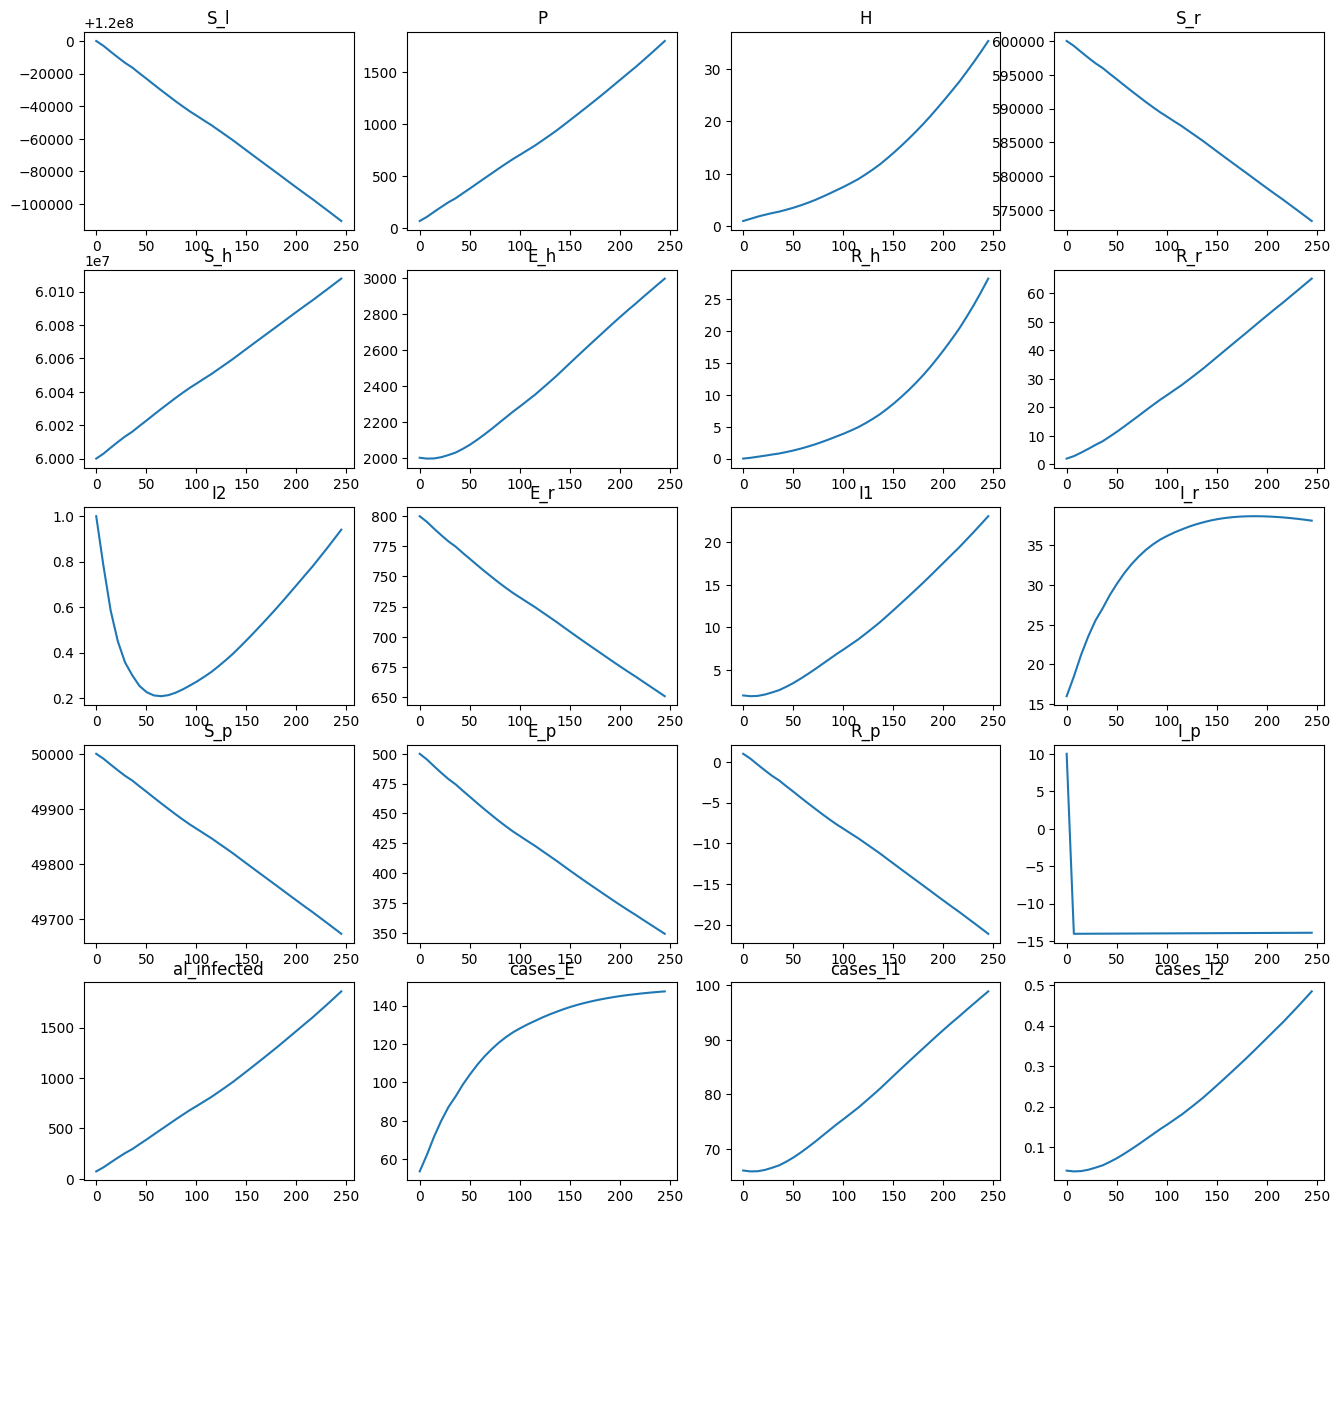

In [14]:
om.plot_simulation_results(times, res)